# EDA: Task 01

### Importing the environment: 

In [18]:
#1# Important libraries:
import pandas as pd  #panda library
import numpy as np   #numpy library
import missingno as msno # data cleaning
import psycopg2    
from sqlalchemy import create_engine  
import os
from dotenv import load_dotenv     
import warnings

warnings.filterwarnings("ignore")

#2# Data visualization: 
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import json


In [19]:
#3# Configuration for graphic plotting:

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Importing the data: 

In [20]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)
cur = conn.cursor()
query_string = "SELECT ks.price , kd.zipcode, kd.grade, kd.bedrooms, kd.bathrooms, kd.sqft_living, kd.sqft_lot15,kd.condition, kd.lat, kd.long, kd.waterfront  FROM eda.king_county_house_details kd FULL JOIN eda.king_county_house_sales ks ON ks.house_id  = kd.id "
df_task_01_original = pd.read_sql(query_string, conn)
df_task_01_original.to_csv('data/eda.csv',index=False)
conn.close()

df_task_01_original = pd.read_csv('data/eda.csv')

### Preparing the data: 

- Creating a copy of the original data:

In [21]:
df_task_01 = df_task_01_original.copy()

- Checking for duplicates:

In [22]:
df_task_01.duplicated().value_counts() 
df_task_01.columns.drop_duplicates()
df_task_01.reset_index(inplace=True, drop=True)
df_task_01.head()

,price,zipcode,grade,bedrooms,bathrooms,sqft_living,sqft_lot15,condition,lat,long,waterfront
0,221900.000,98178,7,3.000,1.000,1180.000,5650.000,3,47.511,-122.257,NaN
1,538000.000,98125,7,3.000,2.250,2570.000,7639.000,3,47.721,-122.319,0.000
2,180000.000,98028,6,2.000,1.000,770.000,8062.000,3,47.738,-122.233,0.000
3,604000.000,98136,7,4.000,3.000,1960.000,5000.000,5,47.521,-122.393,0.000
4,510000.000,98074,8,3.000,2.000,1680.000,7503.000,3,47.617,-122.045,0.000


- Checking for Null values:

In [23]:
df_task_01.isnull().sum()

price             0
zipcode           0
grade             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot15        0
condition         0
lat               0
long              0
waterfront     2391
dtype: int64

In [24]:
#In this case it makes sense to substitute the NaN values with "0" because it's indicating if a house has 
# waterfront or not (it's a categorical feature).

df_task_01.fillna(0, inplace=True)
df_task_01.isnull().sum()

price          0
zipcode        0
grade          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot15     0
condition      0
lat            0
long           0
waterfront     0
dtype: int64

In [25]:
df_task_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   zipcode      21597 non-null  int64  
 2   grade        21597 non-null  int64  
 3   bedrooms     21597 non-null  float64
 4   bathrooms    21597 non-null  float64
 5   sqft_living  21597 non-null  float64
 6   sqft_lot15   21597 non-null  float64
 7   condition    21597 non-null  int64  
 8   lat          21597 non-null  float64
 9   long         21597 non-null  float64
 10  waterfront   21597 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 1.8 MB


- Changing the data type for better visualization:

In [26]:
df_task_01 = df_task_01.astype({"bathrooms": "int64", "bedrooms": "int64", "waterfront": "int64"})

## Analyzing the possible correlations in the data frame:  

First we gonna print a combination of all plots possible considering the elements in our data frame, so we can have a overall idea of what kind of correlations we can find in it. 

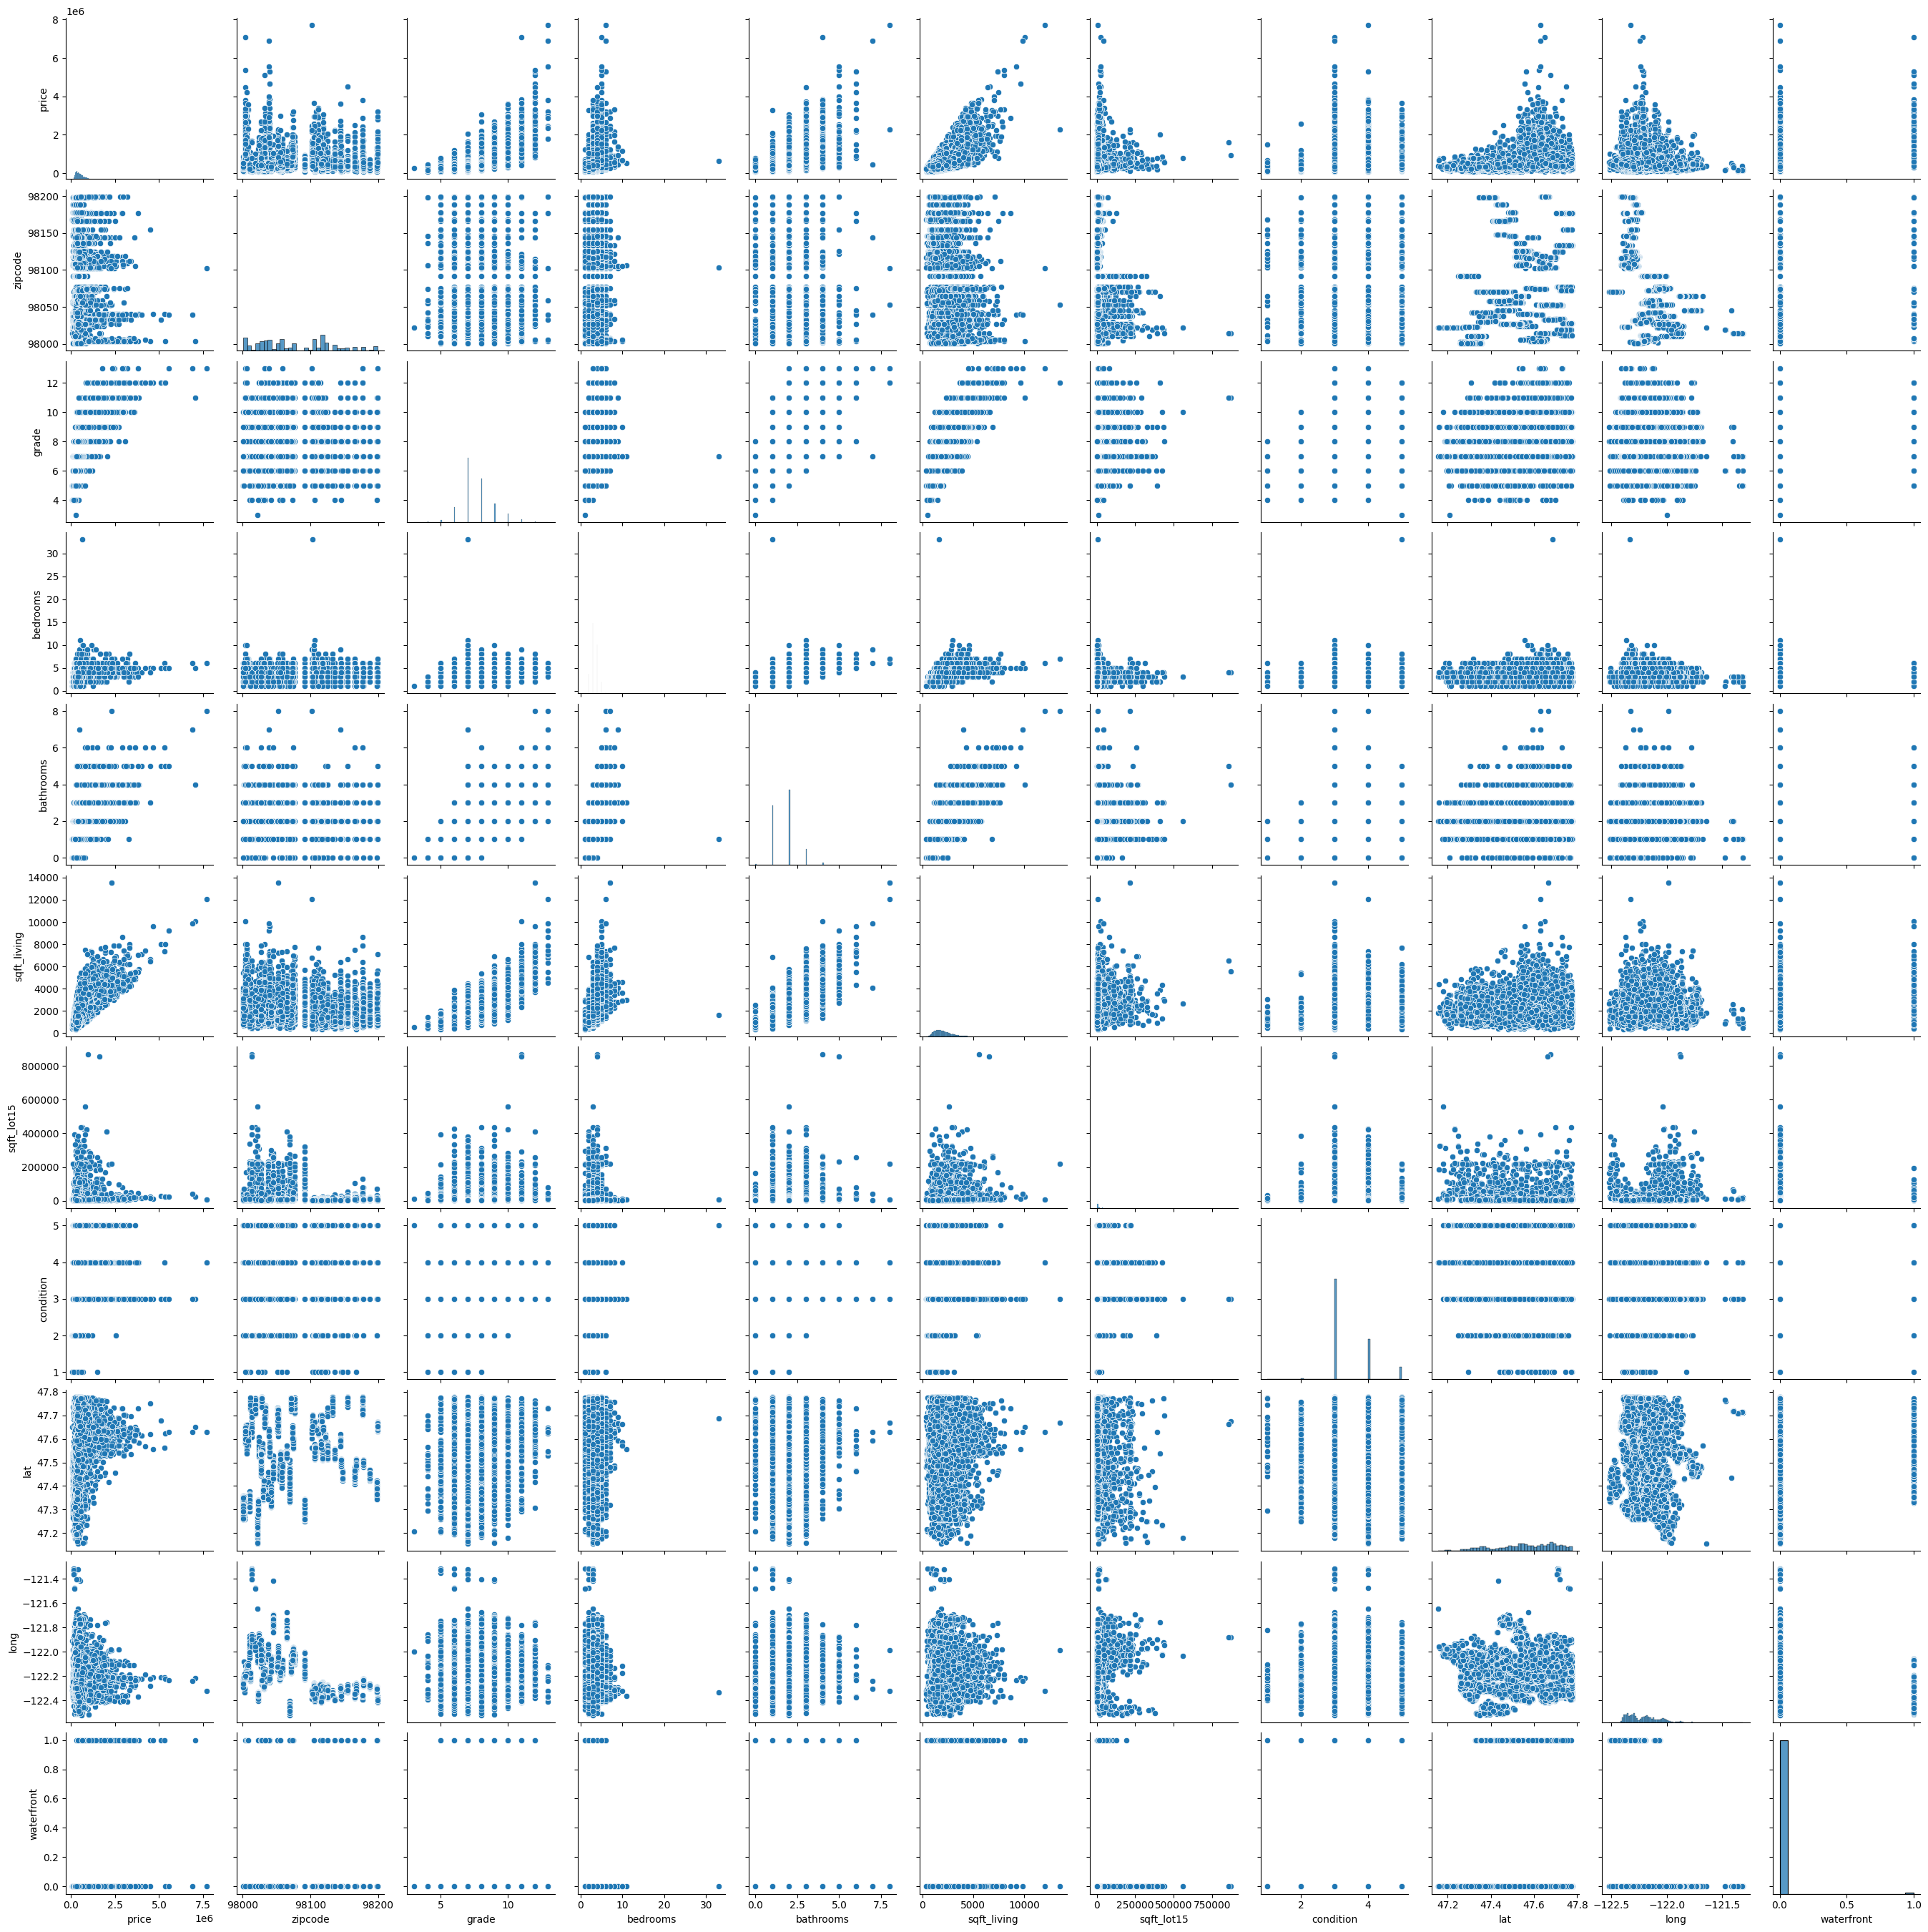

In [27]:
sns.pairplot(df_task_01)


### 1. Price distribution:

Our data frame is a collection of houses to sell and their respective attributes. 
Considering this, a good first plot to get would it the house's price distribution in the map. However the number of rows is originally higher than the limit of data the plot can read. So, first, we'll be sorting according to the house conditions, here we'll be getting only the ones that are in really good conditions. This will give us a idea of the house/price distribution and we'll be able to take two very useful information from it.

In [28]:
houses_in_good_cond = df_task_01.query("condition > 4")

f = open('./data/KCW.geojson', encoding='utf-8')
KCW = json.load(f)
background = alt.Chart(alt.Data(values=KCW)).mark_geoshape(
        fill='white',
        stroke='black',
        #color='ColorS:Q'
        ).project('albersUsa'
        ).properties(
            width=500,
            height=300)
point = alt.Chart(houses_in_good_cond).mark_point(
    opacity=1, color='red'
    ).encode(
    latitude='lat',
    longitude='long',
    color=alt.Color('price', scale = alt.Scale(scheme= 'turbo')),#color='sqft_lots',
    #color=alt.value('red'),
    opacity=alt.value(1)
    )   

background + point

alt.LayerChart(...)

This map not only give us a idea of how expensive or cheap the houses on an certain area but also how far or concentrate they are as well.
We can assume that the area with the bigger amount of marks it's a city center.

Now let's check where the most expensive houses to sell are, assuming this could be a sign that this is a more noble region in the area.

### 2. Identifying the "noble" areas:

In [29]:
## Selecting every house with princes bigger than the average general price and in good conditions:
 
noble_area = houses_in_good_cond.query("price > 645000.000") 

f = open('./data/KCW.geojson', encoding='utf-8')
KCW = json.load(f)
background_1 = alt.Chart(alt.Data(values=KCW)).mark_geoshape(
        fill='white',
        stroke='black',
        #color='ColorS:Q'
        ).project('albersUsa'
        ).properties(
            width=500,
            height=300)
point1 = alt.Chart(noble_area).mark_point(
    opacity=1, color='red'
    ).encode(
    latitude='lat',
    longitude='long',
    color=alt.Color('price', scale = alt.Scale(scheme= 'inferno')),#color='sqft_lots',
    #color=alt.value('red'),
    opacity=alt.value(1)
    )   

background_1 + point1

alt.LayerChart(...)

#### 3. Checking what could be influencing the general price: 

In [30]:
#Checking the values of some interesting features for visualizing in order to avoid confusing plots: 
bedrooms = df_task_01["bedrooms"].unique()
bathrooms = df_task_01["bathrooms"].unique()
conditions = df_task_01["condition"].unique()
grades = df_task_01["grade"].unique()

#Printing the values for analysis:
print("Number of bedrooms:" + str(bedrooms),"\n") 
print("Number of bathrooms:" + str(bathrooms),"\n")
print("Existing grades in the data:" + str(grades),"\n")
print("Existing conditions values in the data:" + str(conditions))

Number of bedrooms:[ 3  2  4  5  1  6  7  8  9 11 10 33] 

Number of bathrooms:[1 2 3 4 0 5 6 8 7] 

Existing grades in the data:[ 7  6  8 11  9  5 10 12  4  3 13] 

Existing conditions values in the data:[3 5 4 1 2]


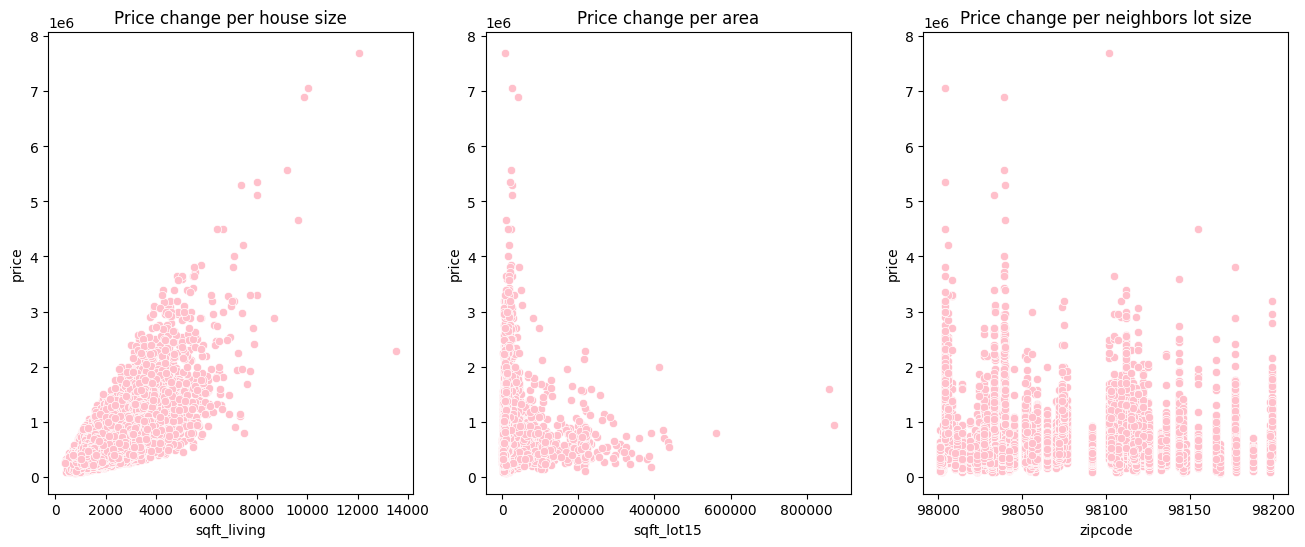

In [31]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax

sns.scatterplot(data=df_task_01, x="sqft_living",y="price",color="pink", ax=ax1)
sns.scatterplot(data=df_task_01, x="zipcode",y="price",color="pink", ax=ax3)
sns.scatterplot(data=df_task_01, x="sqft_lot15",y="price",color="pink", ax=ax2)
##
ax1.set_title('Price change per house size')
ax2.set_title('Price change per area')
ax3.set_title("Price change per neighbors lot size")

fig.savefig("images_task01/Influences on the house price.png",dpi=300)

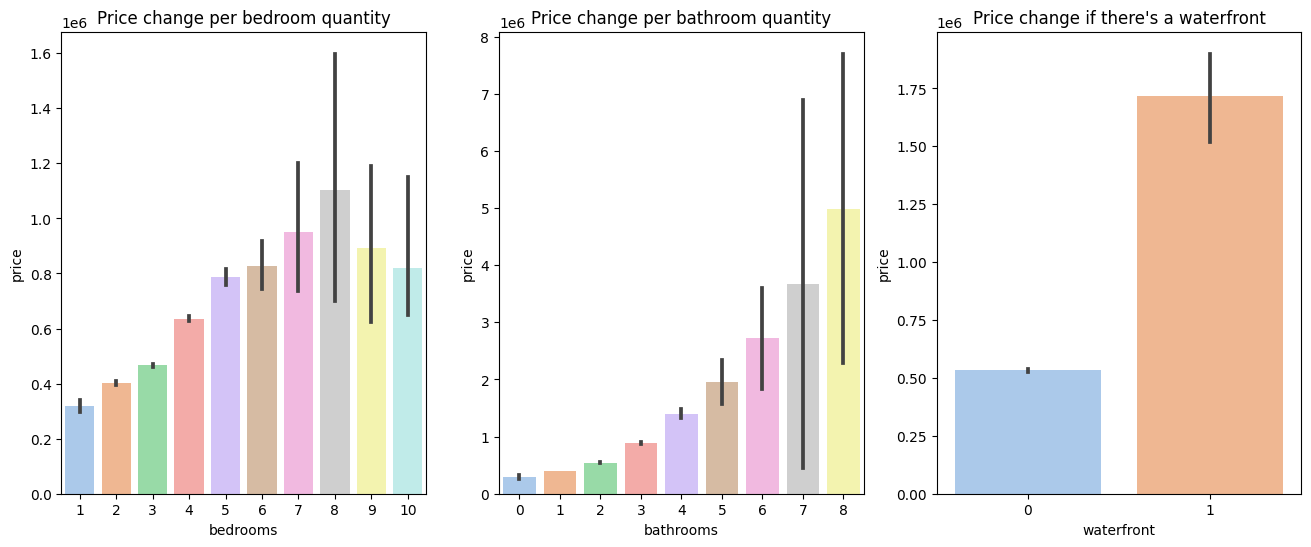

In [32]:
bedrooms_sample = df_task_01.query("bedrooms < 11")

fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax

sns.barplot(data=bedrooms_sample, x="bedrooms",y="price",palette="pastel", ax=ax1)
sns.barplot(data=df_task_01, x="bathrooms",y="price",palette="pastel", ax=ax2)
sns.barplot(data=df_task_01, x="waterfront",y="price",palette="pastel", ax=ax3)
ax1.set_title('Price change per bedroom quantity')
ax2.set_title('Price change per bathroom quantity')
ax3.set_title("Price change if there's a waterfront")
fig.savefig("images_task01/Influence of the house structure in the house price.png",dpi=300)

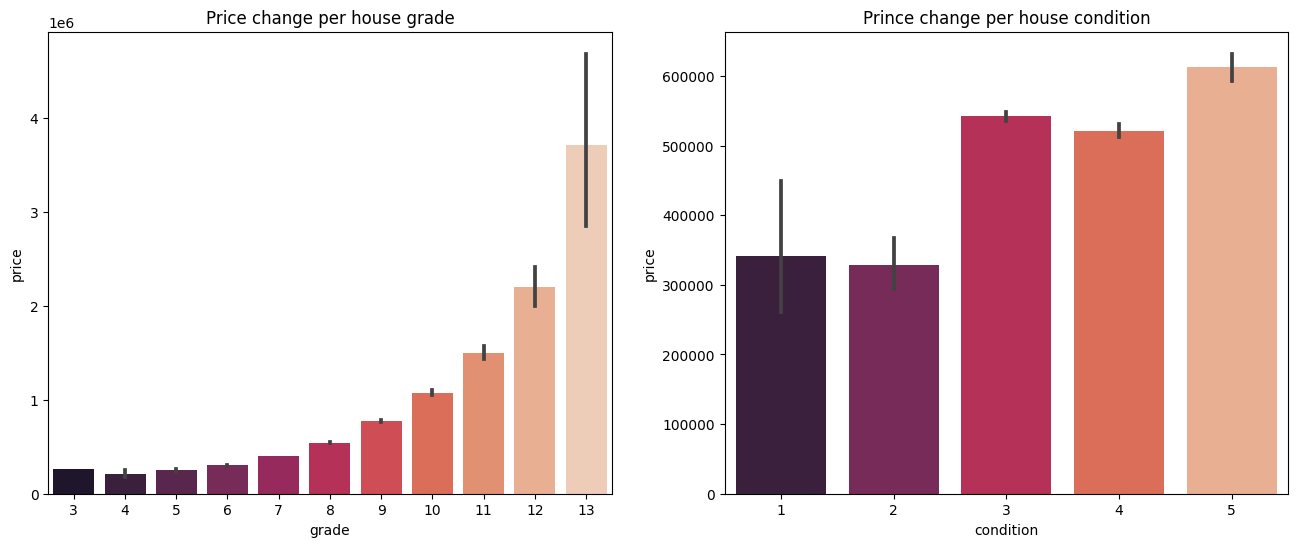

In [33]:
fig , ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1,ax2 = ax

sns.barplot(data=df_task_01, x="grade",y="price",palette="rocket", ax=ax1)
sns.barplot(data=df_task_01, x="condition",y="price",palette="rocket", ax=ax2)
ax1.set_title('Price change per house grade')
ax2.set_title('Prince change per house condition')
fig.savefig("images_task01/Influence of the house conditions and grade in the house price.png",dpi=300)

- Checking what could be influencing the grades:

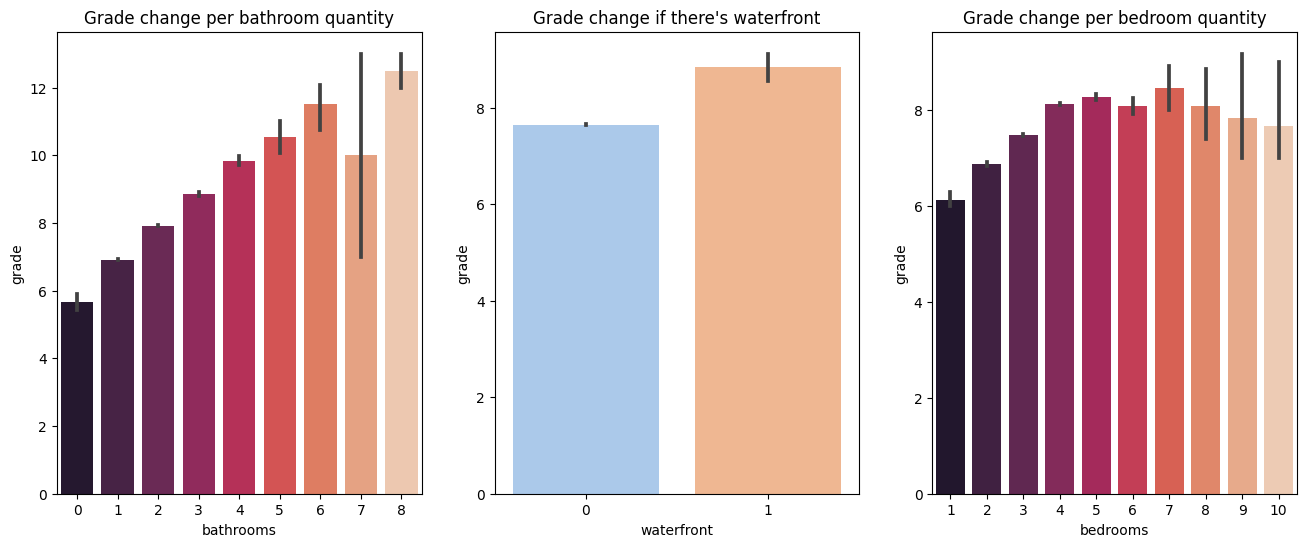

In [34]:
## Analyzing some aspects of the house structure that can affect the grade:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax

sns.barplot(data=df_task_01, y="grade",x="bathrooms",  palette="rocket", ax=ax1)
sns.barplot(data=bedrooms_sample, y="grade",x="bedrooms",  palette="rocket",  ax=ax3)
sns.barplot(data=df_task_01, y="grade", x="waterfront",  palette="pastel", ax=ax2)
ax1.set_title('Grade change per bathroom quantity')
ax2.set_title("Grade change if there's waterfront")
ax3.set_title('Grade change per bedroom quantity')
fig.savefig("images_task01/Influence of the house structure in the house grade.png",dpi=300)


- Analysing the central areas:

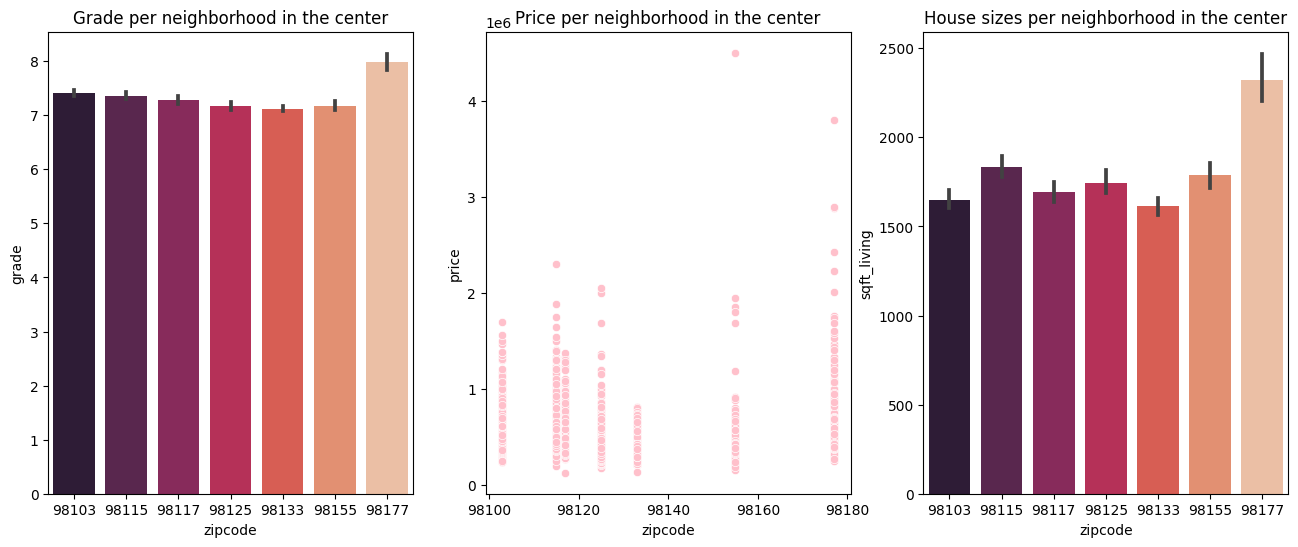

In [35]:
central_areas = df_task_01.query("zipcode == 98177 or zipcode == 98155 or zipcode == 98125 or zipcode == 98133 or zipcode == 98117or zipcode == 98115 or zipcode == 98103")

fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax

sns.barplot(data=central_areas, x="zipcode",y="grade", palette="rocket",ax=ax1)
sns.scatterplot(data=central_areas, x="zipcode",y="price",color="pink", ax=ax2)
sns.barplot(data=central_areas, x="zipcode", y="sqft_living", palette="rocket", ax=ax3)
ax1.set_title('Grade per neighborhood in the center')
ax2.set_title("Price per neighborhood in the center")
ax3.set_title('House sizes per neighborhood in the center')
fig.savefig("images_task01/Basic categories for a good house choice in the center neighborhood.png",dpi=300)

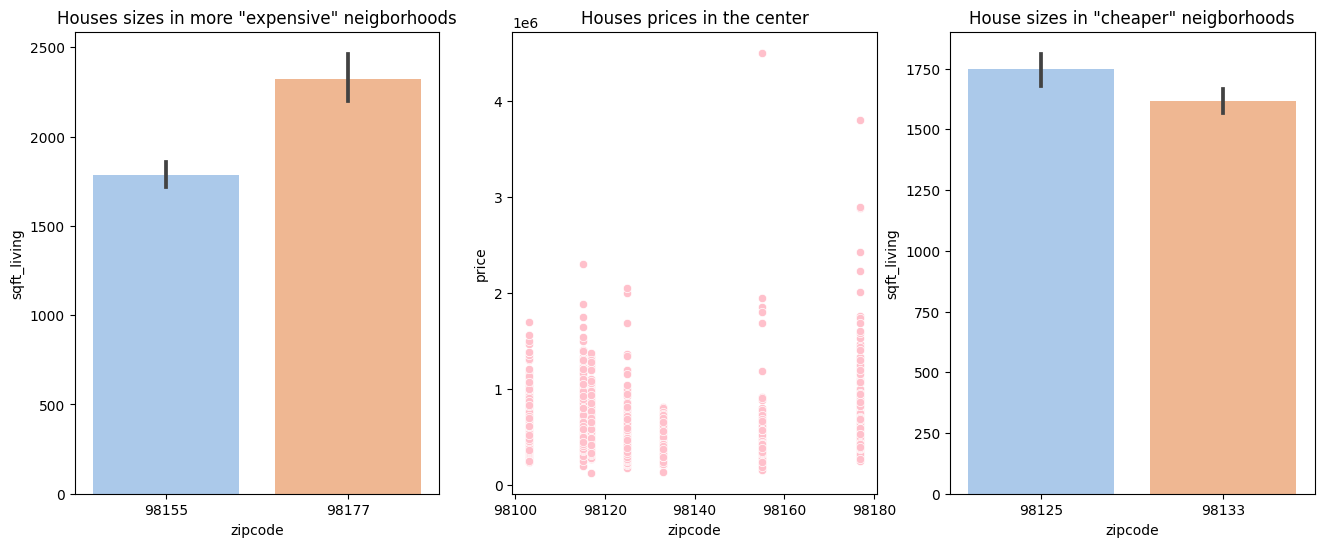

In [36]:
## Comparing the price of houses in two different central areas by their Zipcode

cheaper_area = central_areas.query("zipcode > 98118 and zipcode < 98140")
expensive_area = central_areas.query("zipcode > 98150 and zipcode < 98190")

expensive = expensive_area.groupby(["zipcode"])["price"].mean().reset_index()
cheaper = cheaper_area.groupby(["zipcode"])["price"].mean().reset_index()

## Comparing the house size in those areas with the general price distribution: 

fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))
ax1,ax2,ax3 = ax

sns.scatterplot(data=central_areas, x="zipcode",y="price",color="pink", ax=ax2)
sns.barplot(data=expensive_area, x="zipcode",y="sqft_living",  palette="pastel", ax=ax1)
sns.barplot(data=cheaper_area, x="zipcode", y="sqft_living",  palette="pastel", ax=ax3)
ax1.set_title('Houses sizes in more "expensive" neigborhoods')
ax2.set_title('Houses prices in the center') # identifying were we have more and less expensive house prices
ax3.set_title('House sizes in "cheaper" neigborhoods')
fig.savefig("images_task01/Comparing the house sizes in different areas based on the price distribution.png",dpi=300)